In [22]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
import seaborn as sns

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [2]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(loss)
importlib.reload(reverse_se3_diffusion)
importlib.reload(train_se3_diffusion)
importlib.reload(inference_se3_diffusion)

<module 'experiments.inference_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/experiments/inference_se3_diffusion.py'>

In [3]:
inference_conf_path = '../config/inference.yaml'
inference_conf = OmegaConf.load(inference_conf_path)

In [4]:
inference_conf.ckpt_dir = '../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s'
inference_conf.default_conf_path = '../config/base.yaml'
inference_conf.output_dir = '../results'

print(OmegaConf.to_yaml(inference_conf))

ckpt_dir: ../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s
output_dir: ../results
default_conf_path: ../config/base.yaml
samples_per_length: 10
sequence_length_range:
- 80
- 120
- 200
add_noise: true



In [5]:
sampler = inference_se3_diffusion.Sampler(inference_conf)

INFO: Loading checkpoint from ../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s/epoch_51.pkl
INFO: Saving results to ../results/subset_1000_31D_08M_2022Y_14h_59m_25s
INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.


In [57]:
batch_size = 16
num_res = 100
save = False
samples_traj = sampler.sample(batch_size, num_res, save=save)

In [33]:
final_sample = samples_traj[2, -1]
final_sample_ca_pos = du.move_to_np(final_sample[:, 4:]) * sampler.scale_factor
bond_dists = np.linalg.norm(final_sample_ca_pos - np.roll(final_sample_ca_pos, 1, axis=0), axis=-1)[1:]

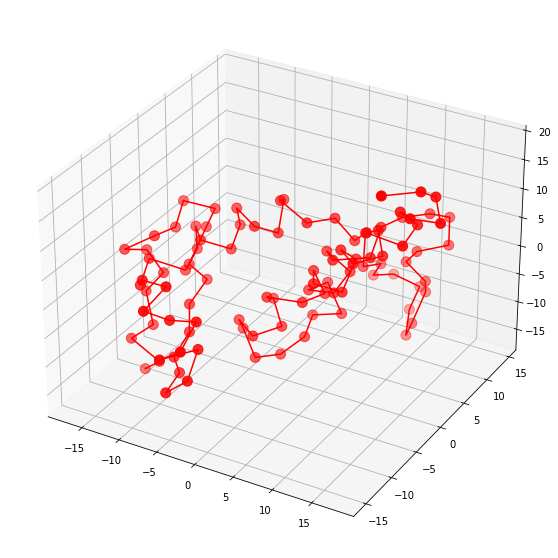

In [26]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(final_sample_ca_pos, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(final_sample_ca_pos, ax, color='r', mode='line')
# plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
# plotting.plt_3d(gt_ca, ax, color='b', mode='line')

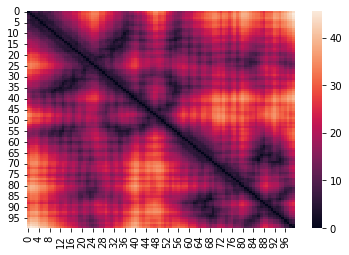

In [28]:
dist_mat = np.linalg.norm(final_sample_ca_pos[None] - final_sample_ca_pos[:, None], axis=-1)
ax = sns.heatmap(dist_mat)

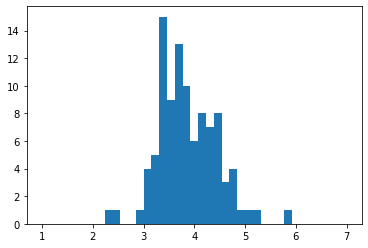

In [39]:
bins = np.linspace(1, 7, 40)
_ = plt.hist(bond_dists, bins=bins)

In [49]:
# Plot bond distance throughout the trajectory
b_idx = 2
b_traj = samples_traj[b_idx]
traj_ca = du.move_to_np(b_traj[:, :, 4:]) * sampler.scale_factor

In [51]:
traj_bond_dists = np.linalg.norm(traj_ca - np.roll(traj_ca, 1, axis=1), axis=-1)[:, 1:]

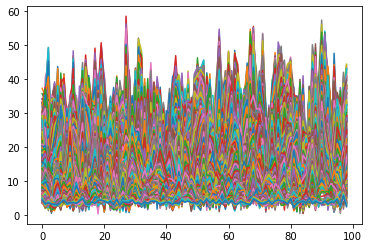

In [56]:
for i in range(traj_bond_dists.shape[0]):
    plt.plot(traj_bond_dists[i])

## Analyze bond distances for each model

In [ ]:
inference_conf.default_conf_path = '../config/base.yaml'
inference_conf.output_dir = '../results'

batch_size = 16
num_res = 100
save = False


inference_conf.ckpt_dir = '../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s'
samples_traj = sampler.sample(batch_size, num_res, save=save)

In [125]:
# Plot bond distance throughout the trajectory
bins = np.linspace(2, 6, 40)

def run_model(model_name, sampler, ax):
    samples_traj = sampler.sample(batch_size, num_res, save=save)
    final_sample = samples_traj[:, -1]
    final_ca = du.move_to_np(final_sample[..., 4:]) * sampler.scale_factor
    final_bond_dists = np.linalg.norm(
        final_ca - np.roll(final_ca, 1, axis=-2),
        axis=-1)[..., 1:]
    ax.hist(
        final_bond_dists.flatten(),
        bins=bins,
        density=True,
        label=model_name,
        histtype='step'
    )
    return final_bond_dists

In [126]:
# Load sampler for each model
models = [
    ('baseline', '../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s'),
    ('exp_lin', '../pkl_jar/ckpt/subset_1000_exp_lin_31D_08M_2022Y_15h_49m_56s'),
    ('lin_lin', '../pkl_jar/ckpt/subset_1000_lin_lin_31D_08M_2022Y_15h_00m_54s'),
    ('lin_log', '../pkl_jar/ckpt/subset_1000_lin_log_01D_09M_2022Y_00h_54m_28s'),
    ('lin_log_3', '../pkl_jar/ckpt/subset_1000_lin_log_3_01D_09M_2022Y_02h_48m_00s'),
    ('lin_log_4', '../pkl_jar/ckpt/subset_1000_lin_log_4_01D_09M_2022Y_02h_47m_59s'),
]
model_samplers = {}
for model_name, ckpt_dir in models:
    inference_conf.ckpt_dir = ckpt_dir
    model_samplers[model_name] = inference_se3_diffusion.Sampler(inference_conf)


INFO: Loading checkpoint from ../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s/epoch_51.pkl
INFO: Saving results to ../results/subset_1000_31D_08M_2022Y_14h_59m_25s
INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loading checkpoint from ../pkl_jar/ckpt/subset_1000_exp_lin_31D_08M_2022Y_15h_49m_56s/epoch_51.pkl
INFO: Saving results to ../results/subset_1000_exp_lin_31D_08M_2022Y_15h_49m_56s
INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loading checkpoint from ../pkl_jar/ckpt/subset_1000_lin_lin_31D_08M_2022Y_15h_00m_54s/epoch_51.pkl
INFO: Saving results to ../results/subset_1000_lin_lin_31D_08M_2022Y_15h_00m_54s
INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loading checkpoint from ../pkl_jar/ckpt/subset_1000_lin_log_01D_09M_2022Y_00h_54m_28s/epoch_51.pkl
INFO: Saving results to ../results/subset_1000_lin_log_01D_09M_2022Y_00h_54m_28s
INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO

Done with baseline
Done with exp_lin
Done with lin_lin
Done with lin_log
Done with lin_log_3
Done with lin_log_4


Text(0, 0.5, 'Density')

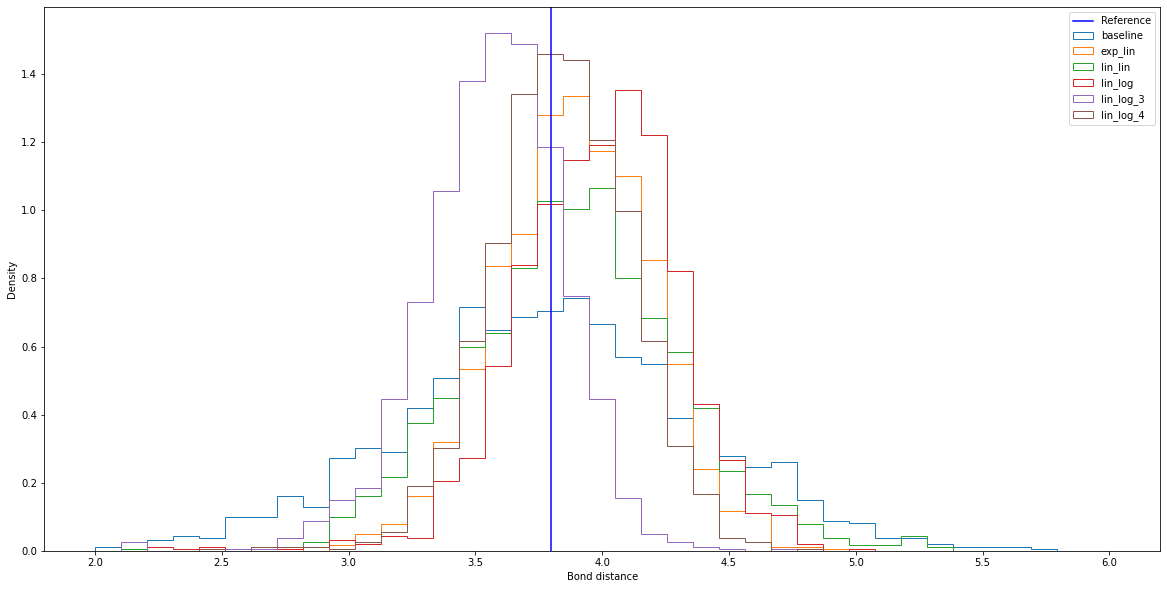

In [127]:
fig, axes = plt.subplots(1, 1, figsize=[20, 10])
axes.axvline(x=3.8, color='b', label='Reference')

model_dists = {}
for model_name, model_runner in model_samplers.items():
    bond_dists = run_model(model_name, model_runner, axes)
    model_dists[model_name] = bond_dists
    print(f'Done with {model_name}')
plt.legend()
plt.xlabel('Bond distance')
plt.ylabel('Density')

In [130]:
for model_name, bond_dists in model_dists.items():
    bond_dev = np.abs(bond_dists - 3.8)
    average_dev = np.mean(bond_dev)
    std_dev = np.std(bond_dev)
    print(f'{model_name}: mean={average_dev}, std={std_dev}')

baseline: mean=0.4656834602355957, std=0.3858426809310913
exp_lin: mean=0.2544066607952118, std=0.1936798095703125
lin_lin: mean=0.33568325638771057, std=0.2737412452697754
lin_log: mean=0.3019539713859558, std=0.24485929310321808
lin_log_3: mean=0.2861063778400421, std=0.2523120045661926
lin_log_4: mean=0.21850228309631348, std=0.17545095086097717


In [103]:
# Plot bond distance throughout the trajectory
bins = np.linspace(1, 7, 40)

def run_model(model_name, ckpt_dir):
    inference_conf.ckpt_dir = ckpt_dir
    sampler = inference_se3_diffusion.Sampler(inference_conf)
    samples_traj = sampler.sample(batch_size, num_res, save=save)
    final_sample = samples_traj[:, -1]
    final_ca = du.move_to_np(final_sample[..., 4:]) * sampler.scale_factor
    final_bond_dists = np.linalg.norm(
        final_ca - np.roll(final_ca, 1, axis=-2),
        axis=-1)[..., 1:]
    plt.hist(
        final_bond_dists.flatten(),
        bins=bins,
        density=True,
        label=model_name
    )

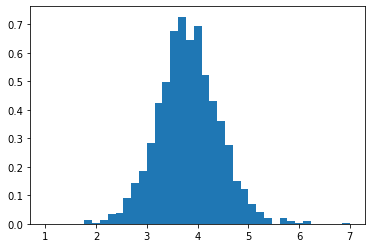

In [102]:
bins = np.linspace(1, 7, 40)
_ = plt.hist(final_bond_dists.flatten(), bins=bins, density=True)

In [ ]:
final_sample_ca_pos = du.move_to_np(final_sample[:, 4:]) * sampler.scale_factor
bond_dists = np.linalg.norm(final_sample_ca_pos - np.roll(final_sample_ca_pos, 1, axis=0), axis=-1)[1:]

In [42]:
final_sample_ca_pos[97]

array([-14.325989,  -9.120027,  -9.538362], dtype=float32)

In [43]:
final_sample_ca_pos[98]

array([-12.133678 ,  -7.0873413, -14.507851 ], dtype=float32)

In [40]:
np.argmax(bond_dists)

97

In [17]:
final_sample_ca_pos = du.move_to_np(final_sample[:, 4:]) * sampler.scale_factor

In [18]:
np.linalg.norm(final_sample_ca_pos - np.roll(final_sample_ca_pos, 1), axis=-1)[:-1]

array([26.573318 , 22.506685 , 24.04984  , 21.148796 , 15.62275  ,
       14.448492 , 16.056234 , 10.928658 ,  6.4473634,  9.752471 ,
        9.619845 ,  2.3775349,  4.749974 , 10.038362 ,  9.75906  ,
       11.5591135, 15.211773 , 19.574865 , 18.990124 , 22.647007 ,
       24.588093 , 21.497334 , 18.6817   ,  9.123522 ,  7.5797696,
        3.4799323,  8.337877 , 13.623421 , 11.277797 ,  9.615468 ,
        6.3940716,  9.308357 , 13.2309   , 18.11864  , 24.486866 ,
       26.41395  , 23.918383 , 18.239023 , 15.526808 ,  9.275168 ,
        4.5063615,  2.3456736,  4.771067 ,  7.6392446, 10.748564 ,
       13.473753 , 15.410647 , 12.313199 ,  9.249007 , 11.189083 ,
       14.024326 , 19.933271 , 23.921219 , 24.572264 , 28.398685 ,
       25.515806 , 18.910524 , 18.169088 , 16.108122 , 16.243591 ,
       11.758268 , 14.700899 , 12.601147 , 17.382492 , 22.429342 ,
       25.476751 , 31.6431   , 35.868584 , 31.775017 , 28.165562 ,
       22.381405 , 16.725325 , 10.077908 ,  9.400242 ,  8.0234

In [ ]:
sample_i = final_samples[0]

In [ ]:
sample_i

In [62]:
rigids_init = sampler.diffuser.sample_ref(
    num_res * batch_size 
).to_tensor_7().reshape((batch_size, num_res, 7))
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': torch.ones((batch_size, num_res)),
    'res_idx': torch.tile(
        torch.arange(1, num_res+1)[None], (batch_size, 1)),
}
init_feats = tree.map_structure(lambda x: x.to(sampler.device), init_feats)
infer_out = sampler.exp.inference_fn(
    init_feats, add_noise=True)
sampled_rigids = infer_out[0]

In [64]:
sampled_rigids[-1]

torch.Size([16, 120, 7])

In [ ]:
# Save final design as PDB.
ca_pos = final_rigid[:, 4:] * scale_factor
num_res = du.move_to_np(torch.sum(res_mask))
file_path = f'../samples/pdb/{os.path.basename(ckpt_dir)}/len_{num_res}_sample.pdb'
file_dir = os.path.dirname(file_path)
os.makedirs(file_dir, exist_ok=True)

save_path = au.write_prot_to_pdb(
    du.move_to_np(ca_pos),
    file_path
)
print(f'Written to {save_path}')

In [3]:
base_conf_path = '../config/base.yaml'
base_conf = OmegaConf.load(base_conf_path)

# Load model checkpoint
# ckpt_dir = '../pkl_jar/ckpt/subset_1000_exp_lin_31D_08M_2022Y_15h_49m_56s'
# ckpt_dir = '../pkl_jar/ckpt/subset_1000_lin_lin_31D_08M_2022Y_15h_00m_54s'
# ckpt_dir = '../pkl_jar/ckpt/subset_100_01D_09M_2022Y_02h_47m_59s'
# ckpt_dir = '../pkl_jar/ckpt/baseline_01D_09M_2022Y_05h_20m_34s'
ckpt_dir = '../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s'
# ckpt_dir = '../pkl_jar/ckpt/subset_1000_lin_log_4_01D_09M_2022Y_02h_47m_59s'
# ckpt_dir = '../pkl_jar/ckpt/baseline_01D_09M_2022Y_10h_45m_05s'
# ckpt_dir = '../pkl_jar/ckpt/pdb_lin_log_3_01D_09M_2022Y_11h_25m_32s'


if len(os.listdir(ckpt_dir)) != 1:
    raise ValueError(f'Ambiguous ckpt in {ckpt_dir}')
ckpt_path = os.path.join(
    ckpt_dir, os.listdir(ckpt_dir)[0])
print(ckpt_path)
ckpt_pkl = du.read_pkl(ckpt_path)
ckpt_conf = ckpt_pkl['conf']
ckpt_model = ckpt_pkl['model']


conf = OmegaConf.merge(base_conf, ckpt_conf)
conf.experiment.data_location = 'digs'
conf.data.digs.cache_dir = '../pkl_jar/'

# print(OmegaConf.to_yaml(ckpt_conf))

../pkl_jar/ckpt/subset_1000_31D_08M_2022Y_14h_59m_25s/epoch_51.pkl


In [4]:
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)
exp.model.load_state_dict(ckpt_model)

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loaded data at ../pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1000.pkl
INFO: Loaded data at ../pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1000.pkl


<All keys matched successfully>

In [5]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [6]:
# Preprocess init data
exp_diffuser = exp.diffuser
# batch_idx = 2
# data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
data_feats = traw_data_feats
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

# rigids_0 = rigids_0[torch.where(res_mask.bool())]
# res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.sample_ref(
    num_res,
    impute=ru.Rigid.from_tensor_7(rigids_0)
).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
#     'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(1.0),
    'rot_score_norm': data_feats['rot_score_norm'],
    'trans_score_norm': data_feats['trans_score_norm'],
}

num_res = res_mask.shape[0]
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

Sample length 206


In [ ]:
# Run inference
infer_out = exp.inference_fn(init_feats, add_noise=True)
sample_rigids = infer_out[0]

In [ ]:
# Plot out SE(3)
final_rigid = sample_rigids[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

In [ ]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


In [ ]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')

In [ ]:
# Save final design as PDB.
ca_pos = final_rigid[:, 4:] * scale_factor
num_res = du.move_to_np(torch.sum(res_mask))
file_path = f'../samples/pdb/{os.path.basename(ckpt_dir)}/len_{num_res}_sample.pdb'
file_dir = os.path.dirname(file_path)
os.makedirs(file_dir, exist_ok=True)

save_path = au.write_prot_to_pdb(
    du.move_to_np(ca_pos),
    file_path
)
print(f'Written to {save_path}')

In [ ]:
# Save trajectory as a gif
save_path = 'dev_diffusion_linear.gif'
sample_traj = torch.stack(sample_rigids)[:, 0]
ax_lim = 15
plotting.write_traj(
    sample_traj, res_mask, save_path, ax_lim=ax_lim, scale_factor=scale_factor
)